# Construção de um modelo de metric learning

é preciso reinciar a sessão

In [4]:
!pip install facenet-pytorch opencv-python-headless matplotlib "Pillow<10.0.0"

INFO: pip is looking at multiple versions of facenet-pytorch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 101.4 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: pillow 10.2.0
    Uninstalling pillow-10.2.0:
      Successfully uninstalled pillow-10.2.0
  Attempting uninstall: facenet-pytorch
    Found existing installation: facenet-pytorch 2.6.0
    Uninstalling facenet-pytorch-2.6.0:
      Successfully uninstalled facenet-pytorch-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires pillow>=10.1, but you have pillow 9.5.0 which is incompatible.


Importando bibliotecas

In [1]:
import os
import torch
from facenet_pytorch import InceptionResnetV1, MTCNN
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
#Inicializar MTCNN para detecção e InceptionResnetV1 para embeddings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(image_size=160, margin=20, device=device)
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [3]:
def extrair_face(filepath):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    face = mtcnn(img)
    return face

In [4]:
def get_embedding(face_tensor):
    with torch.no_grad():
        embedding = model(face_tensor.unsqueeze(0).to(device))
    return embedding[0].cpu().numpy()

In [5]:
def construir_banco(diretorio):
    banco = {}
    for pessoa in os.listdir(diretorio):
        path_pessoa = os.path.join(diretorio, pessoa)
        if not os.path.isdir(path_pessoa):
            continue
        banco[pessoa] = []
        for imagem in os.listdir(path_pessoa):
            caminho = os.path.join(path_pessoa, imagem)
            face = extrair_face(caminho)
            if face is not None:
                emb = get_embedding(face)
                banco[pessoa].append(emb)
    return banco

In [6]:
def salvar_banco(banco, nome='banco_faces.pkl'):
    with open(nome, 'wb') as f:
        pickle.dump(banco, f)

def carregar_banco(nome='banco_faces.pkl'):
    with open(nome, 'rb') as f:
        return pickle.load(f)

In [7]:
def reconhecer(face_tensor, banco):
    consulta = get_embedding(face_tensor)
    melhores = []
    for nome, emb_list in banco.items():
        for emb in emb_list:
            score = cosine_similarity([consulta], [emb])[0][0]
            melhores.append((nome, score))
    melhores.sort(key=lambda x: x[1], reverse=True)
    return melhores[0][0], melhores[0][1]

In [8]:
def mostrar_resultado(path_img, banco):
    face = extrair_face(path_img)
    if face is None:
        print("Rosto não detectado.")
        return
    nome, score = reconhecer(face, banco)
    img = cv2.imread(path_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Reconhecido como: {nome}\nThreshold: {score:.4f}")
    plt.show()

In [9]:
def adicionar_pessoa(nome, path_img, banco):
    face = extrair_face(path_img)
    if face is not None:
        emb = get_embedding(face)
        if nome in banco:
            banco[nome].append(emb)
        else:
            banco[nome] = [emb]

In [2]:
"""Esse é o dataset que eu utilizarei, pode ser utilizado qualquer um
desde que se mantenha a estrutura dos diretorios e arquivos.
"""
!unzip dataset.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: post-processed/Michael_Goldrich/Michael_Goldrich_0001_0000.jpg  
  inflating: post-processed/Michael_Goldrich/Michael_Goldrich_0001_0001.jpg  
  inflating: post-processed/Michael_Goldrich/Michael_Goldrich_0002_0000.jpg  
  inflating: post-processed/Michael_Goldrich/Michael_Goldrich_0002_0001.jpg  
  inflating: post-processed/Michael_Goldrich/Michael_Goldrich_0002_0002.jpg  
   creating: post-processed/Michael_Hagee/
  inflating: post-processed/Michael_Hagee/Michael_Hagee_0001_0000.jpg  
  inflating: post-processed/Michael_Hagee/Michael_Hagee_0002_0000.jpg  
   creating: post-processed/Michael_Haneke/
  inflating: post-processed/Michael_Haneke/Michael_Haneke_0001_0000.jpg  
  inflating: post-processed/Michael_Haneke/Michael_Haneke_0001_0001.jpg  
  inflating: post-processed/Michael_Haneke/Michael_Haneke_0002_0000.jpg  
  inflating: post-processed/Michael_Haneke/Michael_Haneke_0004_0000.jpg  
  inflating: post-proces

In [10]:
banco = construir_banco('/content/post-processed')
salvar_banco(banco)

In [12]:
#Adicionar nova pessoa ao banco
adicionar_pessoa("Pierre", "/content/pierre_no_db.jpeg", banco)
salvar_banco(banco)

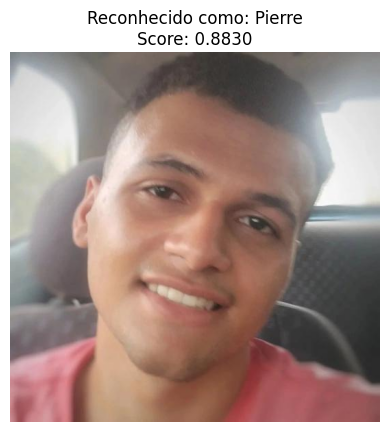

In [13]:
#Realizar inferencia com imagem nova
banco = carregar_banco()
mostrar_resultado('/content/pierre_inferencia.jpg', banco)

# Esse modelo ainda não é preciso, algumas modificações precisam ser feitas para melhorar a acúracia.